# **Mortality Prediction in Patients with AKI**

## **Objectives and Data Description**
The objective is to predict in-hospital mortality in the ICU of a retrospective cohort of patients with AKI. The data comes from the MIMIC-III database. Each registry includes a set of variables that summarize the clinical trajectory of the patients during their stay in the ICU. The target variable, in-hospital mortality (IHM), is defined as a binary variable where the value ’1’ indicates the death of the patient in the ICU.

Slides Link: [Click here to access the slides](https://docs.google.com/presentation/d/1k4ZWldcGJIGgC-Erpj4OkatBuwlwl_CODjVcRbpcw3U/edit?usp=sharing)

In [ ]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# Model Training and Validation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Deep Learning with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

# Metrics
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# Utilities
import joblib
import itertools


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/LindaNciko/Dataset/refs/heads/main/ihm_aki.csv")


## **1. Overview of the Dataset**

In [ ]:
df.head()

,Unnamed: 0,age,gender_F,gender_M,bic_max,bic_mean,bic_min,bilirubin,bp_max,bp_mean,...,pot_mean,pot_min,sod_max,sod_mean,sod_min,temp,wbc_max,wbc_mean,wbc_min,IHM
0,0,74.63,1,0,40.0,34.62,30.0,0.4,154.63,123.28,...,3.85,3.30,143.50,141.50,139.0,NaN,13.70,9.20,6.4,0
1,1,60.12,1,0,34.0,28.94,24.0,0.2,113.12,104.68,...,3.76,2.75,145.00,141.21,139.0,38.04,21.30,17.69,14.4,0
2,2,64.12,1,0,26.0,24.07,21.0,0.3,126.62,108.91,...,3.86,3.50,145.00,140.86,138.0,NaN,33.90,19.39,10.5,0
3,4,54.46,0,1,34.0,30.98,26.0,1.0,151.38,114.38,...,4.17,3.60,147.50,140.43,135.0,36.83,29.00,13.18,2.5,1
4,5,78.22,0,1,29.6,23.10,18.0,1.0,166.26,144.62,...,4.10,3.40,150.25,141.22,136.5,NaN,46.86,8.68,0.3,1


## **Explanation of Variables**

- **age**: The age of the patient, usually measured in years.

- **gender_F**: A binary indicator (0 or 1) representing whether the patient is female (1 for female, 0 for not female).

- **gender_M**: A binary indicator representing whether the patient is male (1 for male, 0 for not male).

- **bic_max**: The maximum value of the Body Mass Index (BMI) recorded for the patient.

- **bic_mean**: The average Body Mass Index (BMI) of the patient over a certain period.

- **bic_min**: The minimum Body Mass Index (BMI) recorded for the patient.

- **bilirubin**: A substance produced from the breakdown of red blood cells; high levels can indicate liver problems.

- **bp_max**: The maximum recorded blood pressure of the patient.

- **bp_mean**: The average blood pressure recorded for the patient.

- **bp_min**: The minimum recorded blood pressure of the patient.

- **bun_max**: The maximum value of Blood Urea Nitrogen (BUN), which can indicate kidney function.

- **bun_mean**: The average Blood Urea Nitrogen (BUN) level for the patient.

- **bun_min**: The minimum Blood Urea Nitrogen (BUN) level recorded.

- **Days_in_uci**: The number of days the patient spent in an Intensive Care Unit (ICU).

- **fio2**: Fraction of inspired oxygen; it indicates the percentage of oxygen in the air that a patient is breathing.

- **gcs_max**: The maximum score on the Glasgow Coma Scale, which measures consciousness levels.

- **gcs_mean**: The average Glasgow Coma Scale score during the patient's stay.

- **gcs_min**: The minimum Glasgow Coma Scale score recorded.

- **hr_max**: The maximum heart rate recorded for the patient.

- **hr_mean**: The average heart rate during monitoring.

- **hr_min**: The minimum heart rate recorded.

- **max pao2**: The maximum partial pressure of oxygen in arterial blood, indicating how well oxygen is being transferred into the blood from the lungs.

- **mean pao2**: The average partial pressure of oxygen in arterial blood during monitoring.

- **min pao2**: The minimum partial pressure of oxygen in arterial blood recorded.

- **pot_max**: The maximum potassium level in the patient's blood, which is important for heart and muscle function.

- **pot_mean**: The average potassium level in the patient's blood during monitoring.

- **pot_min**: The minimum potassium level recorded in the patient's blood.

- **sod_max**: The maximum sodium level in the patient's blood, important for fluid balance and nerve function.

- **sod_mean**: The average sodium level during monitoring.

- **sod_min**: The minimum sodium level recorded in the patient's blood.

- **temp**: The body temperature of the patient, usually measured in degrees Celsius or Fahrenheit.

- **wbc_max**: The maximum white blood cell count, which can indicate infection or inflammation.

- **wbc_mean**: The average white blood cell count during monitoring.

- **wbc_min**: The minimum white blood cell count recorded.

- **IHM**: stands for In-Hospital Mortality, indicating whether a patient died during their hospital stay (often coded as 1 for yes and 0 for no).


## **EDA**

In [ ]:
# General Information
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 36 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   3550 non-null   int64  
 1   age          3550 non-null   float64
 2   gender_F     3550 non-null   int64  
 3   gender_M     3550 non-null   int64  
 4   bic_max      3550 non-null   float64
 5   bic_mean     3550 non-null   float64
 6   bic_min      3550 non-null   float64
 7   bilirubin    2893 non-null   float64
 8   bp_max       3550 non-null   float64
 9   bp_mean      3550 non-null   float64
 10  bp_min       3550 non-null   float64
 11  bun_max      3550 non-null   float64
 12  bun_mean     3550 non-null   float64
 13  bun_min      3550 non-null   float64
 14  Days_in_uci  3550 non-null   float64
 15  fio2         3152 non-null   float64
 16  gcs_max      3550 non-null   float64
 17  gcs_mean     3550 non-null   float64
 18  gcs_min      3550 non-null   float

In [ ]:
# Summary Statistics
print("Summary Statistics:")
print(df.describe().T)

Summary Statistics:
              count         mean          std     min        25%       50%  \
Unnamed: 0   3550.0  2220.038028  1279.998208    0.00  1108.2500  2220.500   
age          3550.0    64.286620    15.986639   16.90    54.1125    66.920   
gender_F     3550.0     0.424507     0.494338    0.00     0.0000     0.000   
gender_M     3550.0     0.575493     0.494338    0.00     0.0000     1.000   
bic_max      3550.0    30.055363     5.032318   14.50    27.0000    30.000   
bic_mean     3550.0    25.606231     4.147980   12.33    23.1250    25.460   
bic_min      3550.0    20.895972     4.388776    5.00    18.0000    21.000   
bilirubin    2893.0     1.586049     3.168970    0.00     0.4000     0.700   
bp_max       3550.0   140.153299    18.630140   90.79   126.5100   140.155   
bp_mean      3550.0   122.734980    14.647909   84.62   111.8750   121.635   
bp_min       3550.0   106.023138    13.324255   44.26    97.0400   104.015   
bun_max      3550.0    49.267746    34.31614

In [ ]:
# Check for Missing Values
print("Missing Values per Column:")
print(df.isnull().sum())

Missing Values per Column:
Unnamed: 0        0
age               0
gender_F          0
gender_M          0
bic_max           0
bic_mean          0
bic_min           0
bilirubin       657
bp_max            0
bp_mean           0
bp_min            0
bun_max           0
bun_mean          0
bun_min           0
Days_in_uci       0
fio2            398
gcs_max           0
gcs_mean          0
gcs_min           0
hr_max            0
hr_mean           0
hr_min            0
max pao2        133
mean pao2       133
min pao2        133
pot_max           0
pot_mean          0
pot_min           0
sod_max           0
sod_mean          0
sod_min           0
temp           1225
wbc_max           0
wbc_mean          0
wbc_min           0
IHM               0
dtype: int64


In [ ]:
# Check for Duplicate Rows
print("Duplicate Rows Count:")
print(df.duplicated().sum())

Duplicate Rows Count:
0


In [ ]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

### 2. **Univariate Analysis**

- Distribution of Numerical Features: visualize the distributions to understand their spread and identify outliers

In [ ]:
df['gender_F'] = df['gender_F'].astype('category')
df['gender_M'] = df['gender_M'].astype('category')


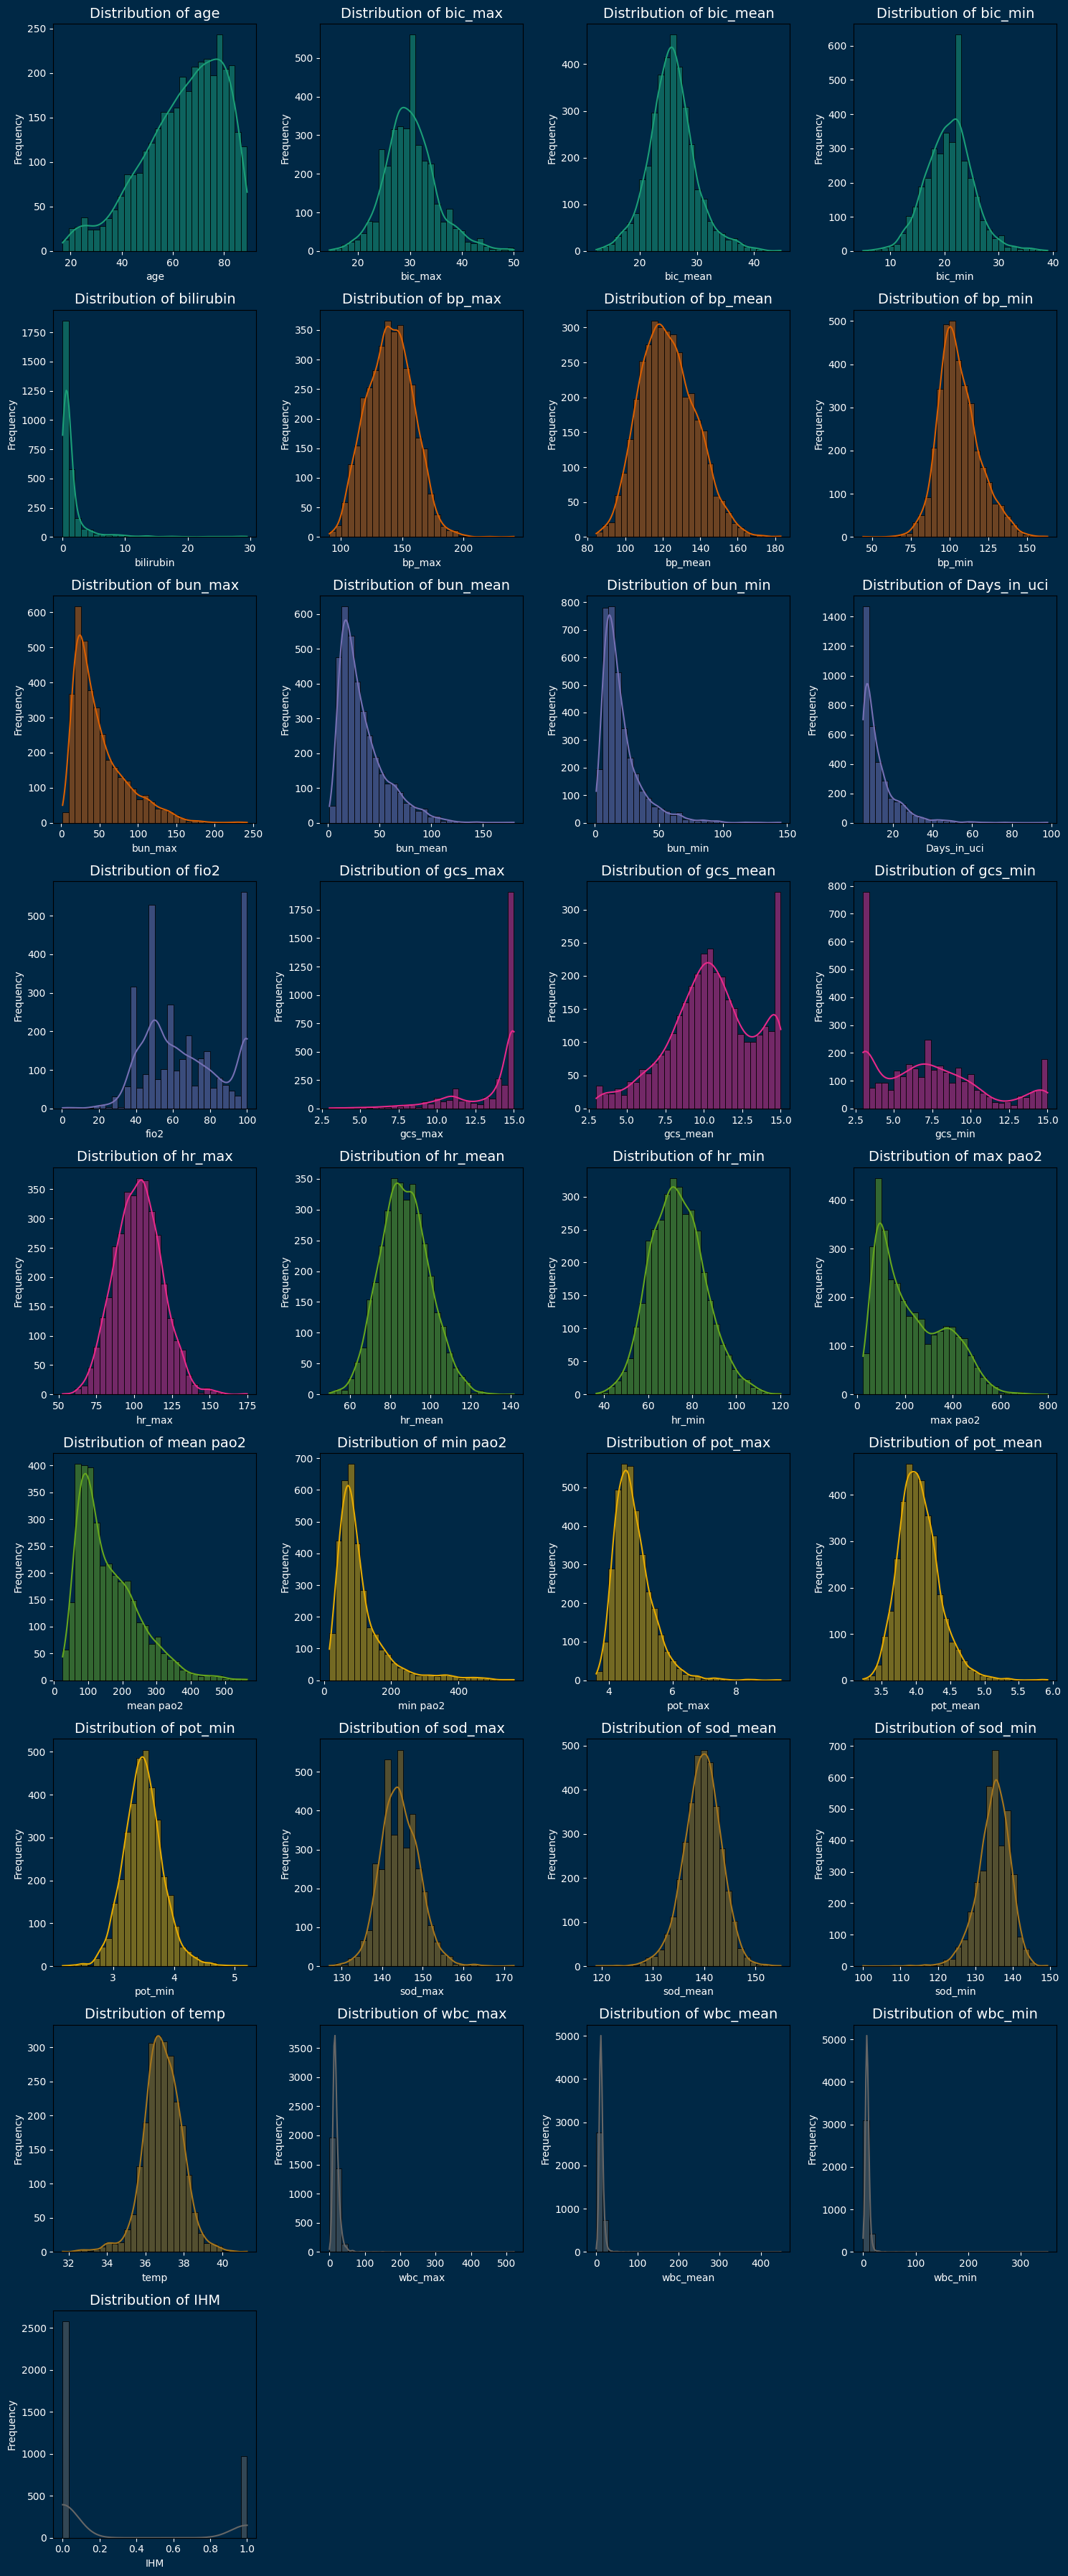

In [ ]:
numerical_cols = df.select_dtypes(include='number').columns.tolist()

n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

axes = axes.flatten()

# Set figure background color
fig.patch.set_facecolor('#002845')

palette = plt.cm.Dark2

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, bins=30, color=palette(i / len(numerical_cols)), ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", color='white', fontsize=14)  # White title
    axes[i].set_xlabel(col, color='white')
    axes[i].set_ylabel("Frequency", color='white')
    axes[i].tick_params(axis='both', colors='white')

    axes[i].set_facecolor('#002845')

for j in range(len(numerical_cols), len(axes)):
    axes[j].axis('off')

# Adjust layout for tightness
plt.tight_layout()
plt.show()

We can observe that most of the features exhibit a right-skewed distribution, indicating a higher frequency of lower values ​​and a tail towards higher values. This is particularly evident in features like Age, Total_Bilirubin, Alkaline_Phosphotase, Albumin, and Total_Protiens. Some features, such as Direct_Bilirubin, Total_Bilirubin, and Alkaline_Phosphotase, show a bimodal distribution, suggesting the presence of two distinct groups within the data. Additionally, the histograms reveal potential outliers in some features, which could be further investigated for their impact on the analysis. Overall, these histograms provide valuable insights into the data's characteristics and help inform further data analysis and modeling.

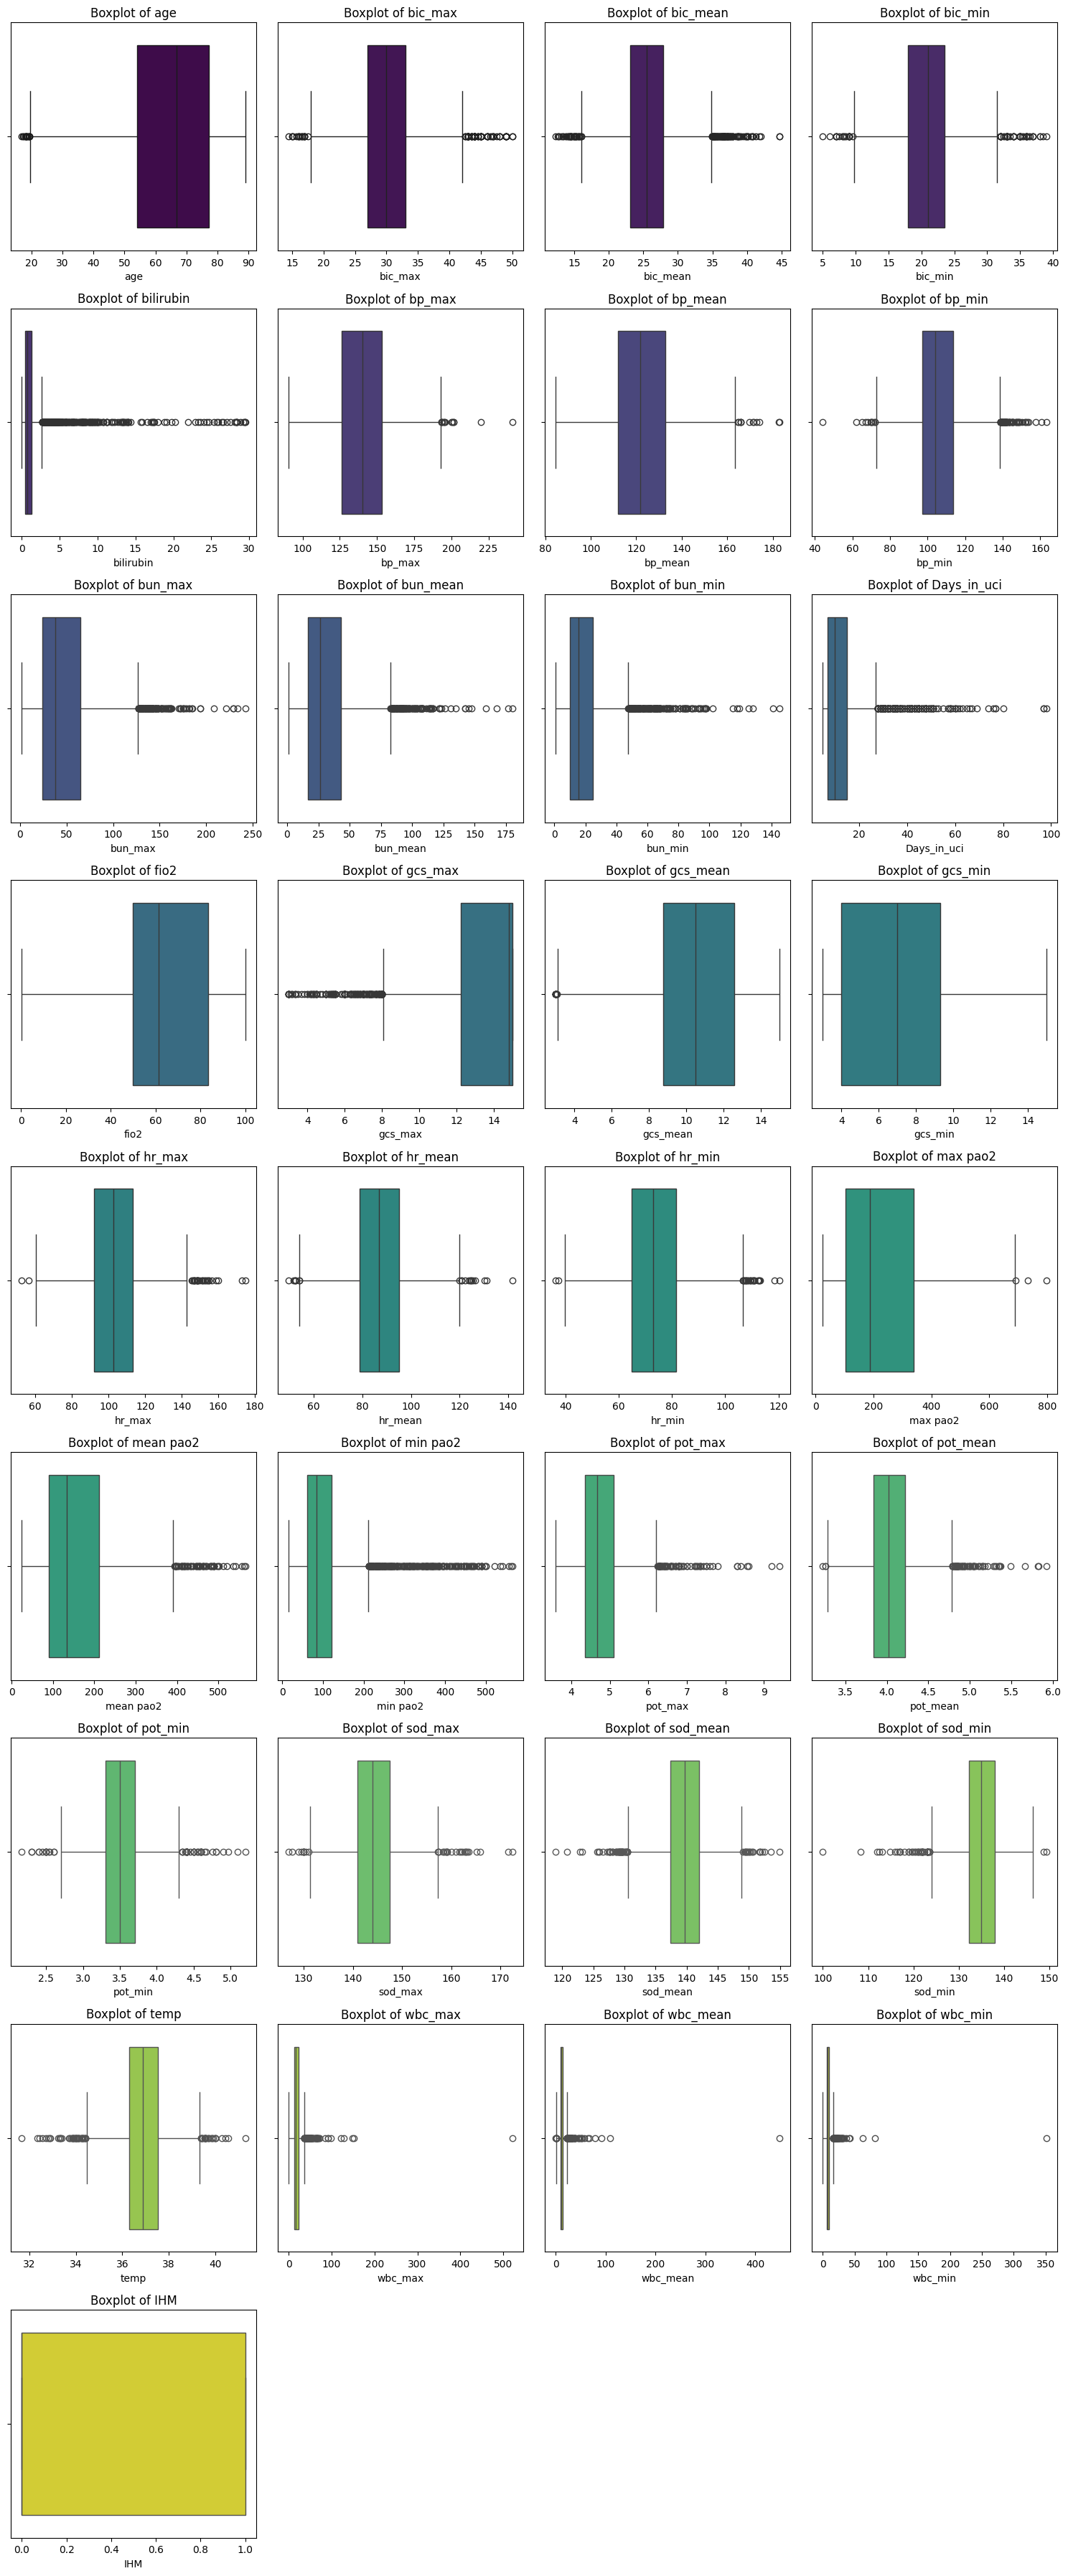

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

palette = plt.cm.viridis

# Plot each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df[col], color=palette(i / len(numerical_cols)), ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


We can observe that most of the features exhibit a right-skewed distribution, as indicated by the longer whisker on the right side of the boxplots. This suggests a higher frequency of lower values ​​and a tail towards higher values. Additionally, the presence of outliers is evident in several features, represented by the data points beyond the whiskers. These outliers could potentially influence the analysis and may need to be addressed accordingly. The boxplots also reveal varying degrees of spread in the data, with some features having a wider range of values ​​than others. Overall, these boxplots provide a visual representation of the data's distribution and highlight potential areas of interest for further investigation.

### 3. **Bivariate Analysis**

- Correlation Analysis

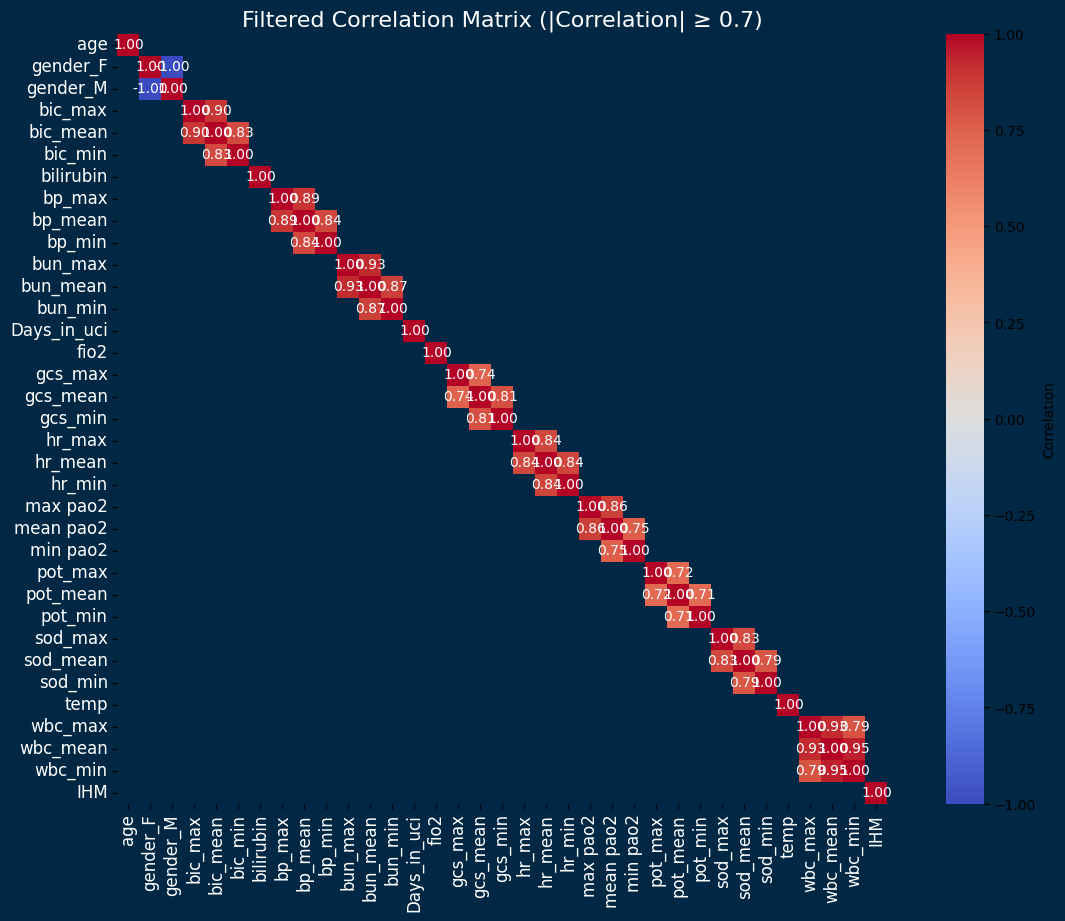

In [ ]:
corr_matrix = df.corr()

# Apply a threshold: Keep only values above 0.7 (or -0.7 for negative correlations)
threshold = 0.7
filtered_corr = corr_matrix.applymap(lambda x: x if abs(x) >= threshold else np.nan)

# Plot the heatmap
plt.figure(figsize=(15, 10))
plt.gcf().set_facecolor('#002845')

ax = sns.heatmap(
    filtered_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    mask=filtered_corr.isnull(),
    annot_kws={"color": "white"},
    cbar_kws={'label': 'Correlation'},
    square=True
)

# Set the axes background color
ax.set_facecolor('#002845')

# Customize title and axis labels for visibility
plt.title("Filtered Correlation Matrix (|Correlation| ≥ 0.7)", color='white', fontsize=16)
plt.xticks(color='white', fontsize=12)
plt.yticks(color='white', fontsize=12)

ax.grid(False)

plt.show()

These correlations suggest that these variables are closely related and may influence each other. It's important to note that correlation does not imply causation, and further analysis is needed to understand the underlying
1
relationships between these variables

#### *3.2*. **Relationship with Target Variable (IHM): Analyze the relationships between each feature and IHM (target variable).**

- Boxplots

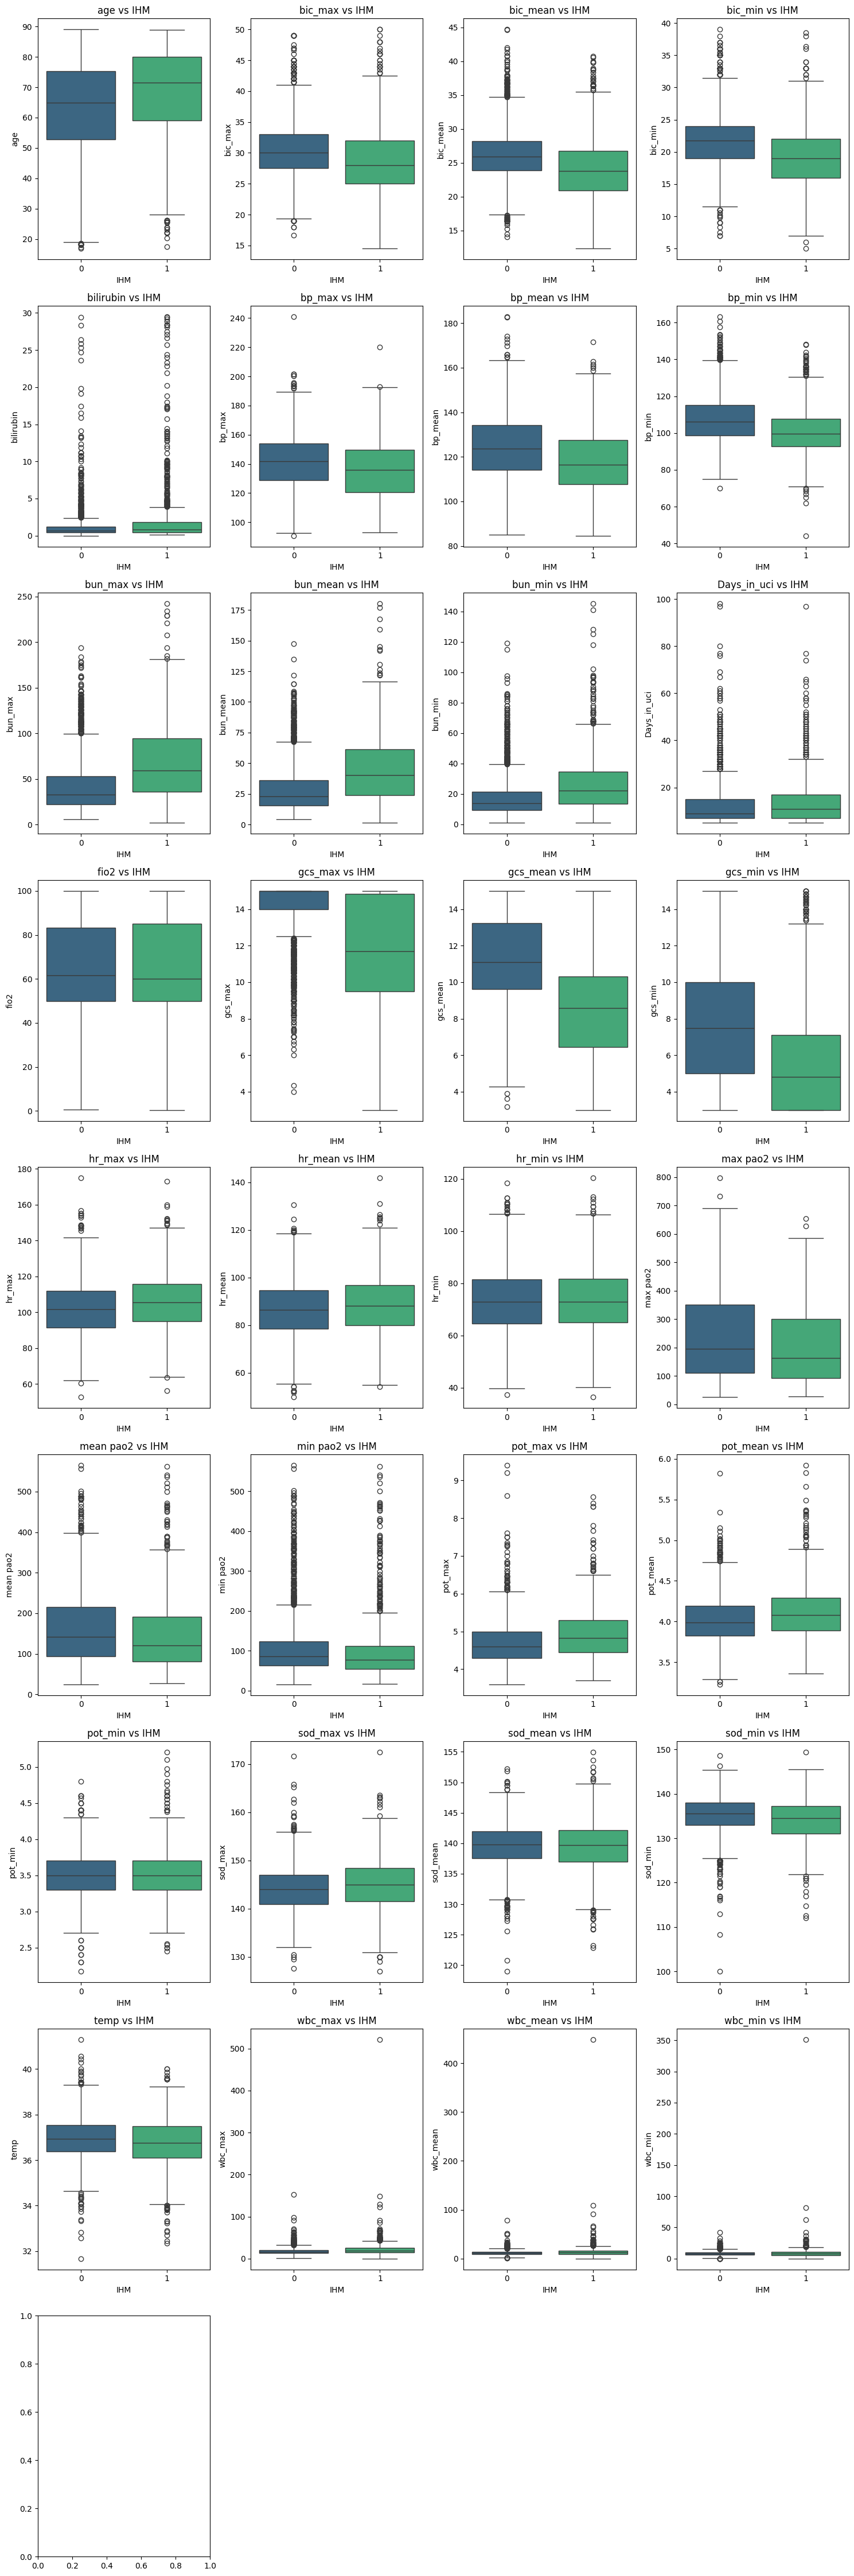

In [ ]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

palette = "viridis"

for i, col in enumerate(numerical_cols):
    if col != 'IHM':
        sns.boxplot(x='IHM', y=col, data=df, ax=axes[i], palette=palette)
        axes[i].set_title(f"{col} vs IHM")
        axes[i].set_xlabel('IHM')
        axes[i].set_ylabel(col)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


By comparing the boxplots for each feature, we can observe potential differences between the two groups. For example, if the median line of one group's boxplot is significantly higher or lower than the other group's, it suggests a difference in the central tendency of that feature between the two groups. Similarly, if the interquartile range (the box portion) or the whiskers are significantly different, it indicates a difference in the variability or spread of the data for that feature.

However, it's important to note that these are just visual observations. Statistical tests would be needed to determine if the observed differences are statistically significant. Additionally, the specific context and the features being compared would influence the interpretation of the results.









- Mean Comparison:

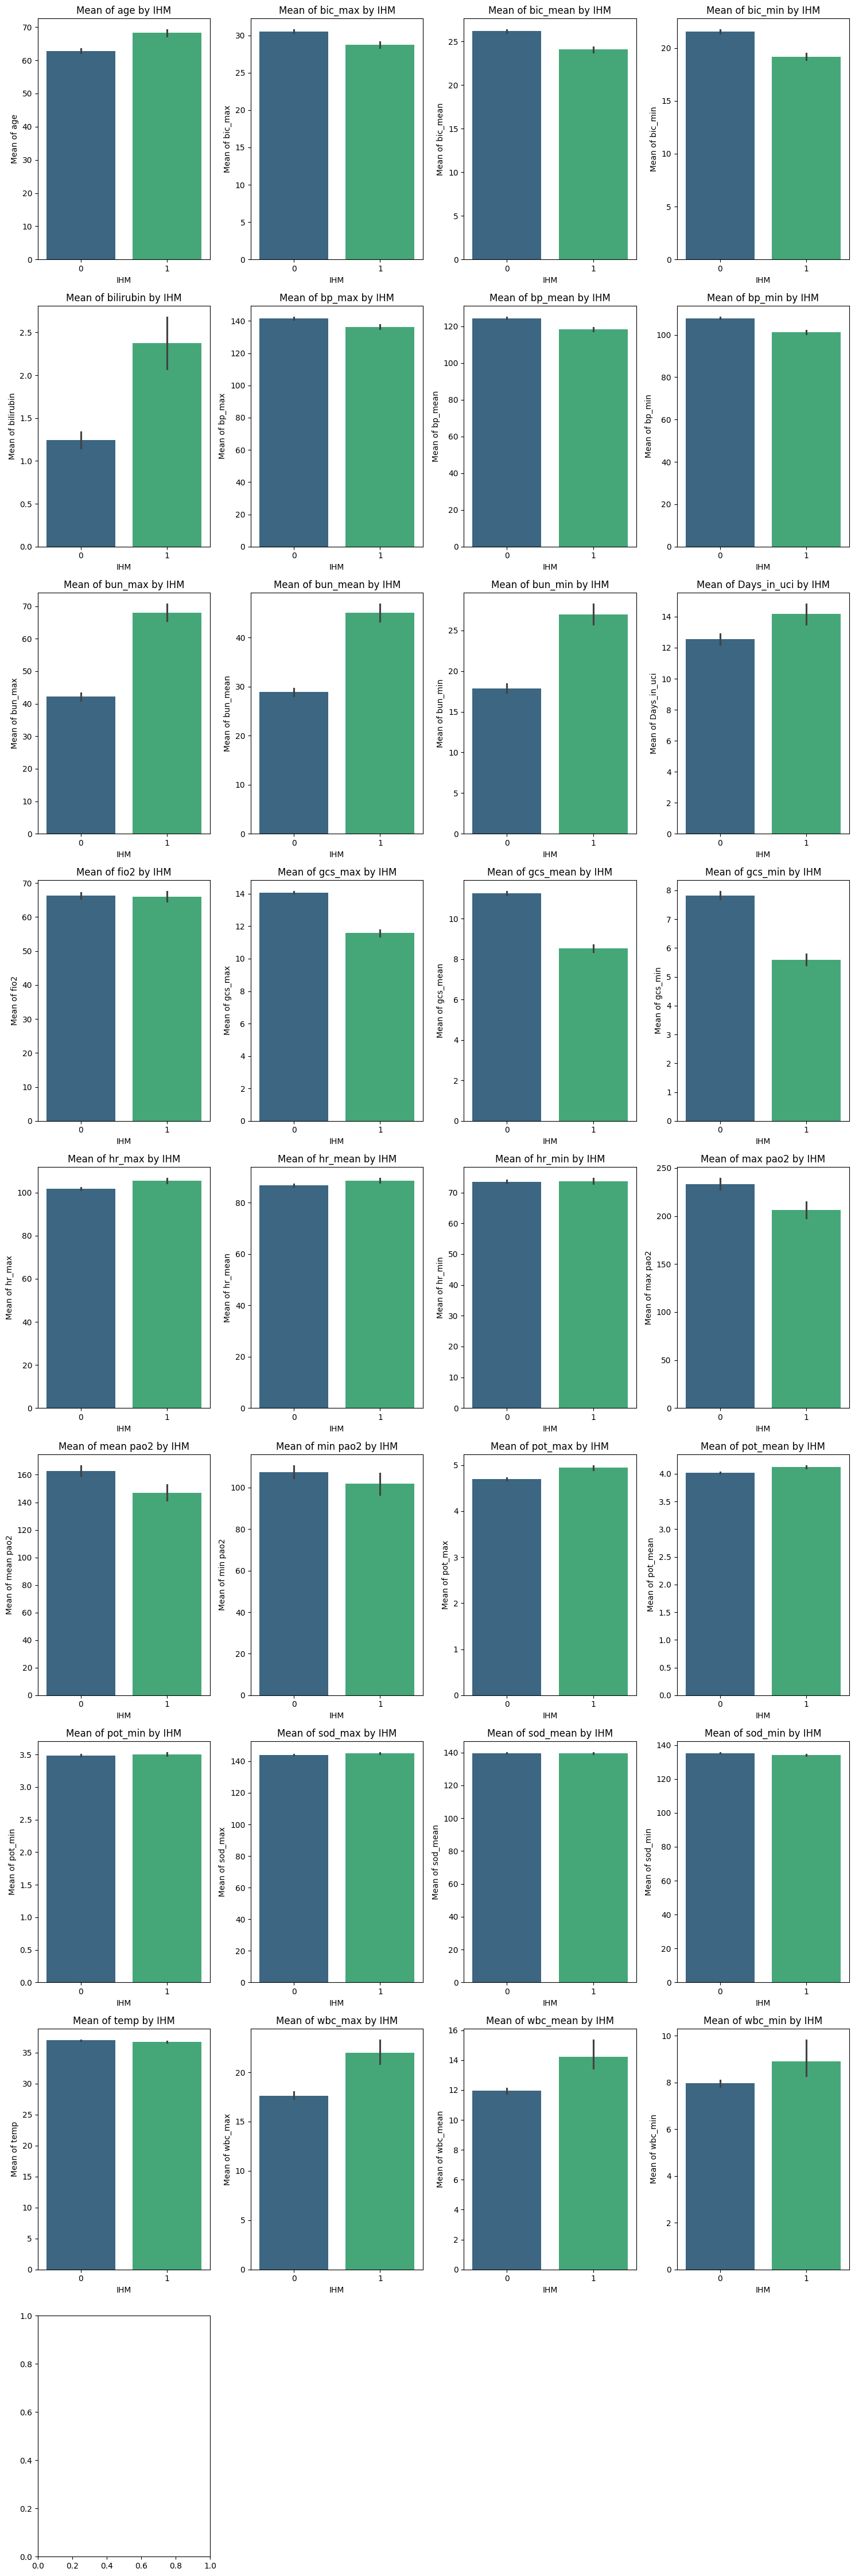

In [ ]:
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if col != 'IHM':
        sns.barplot(x='IHM', y=col, data=df, ax=axes[i], palette="viridis")
        axes[i].set_title(f"Mean of {col} by IHM")
        axes[i].set_xlabel('IHM')
        axes[i].set_ylabel(f"Mean of {col}")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


The boxes  visualize atients with high and low Intensive Health Monitor (IHM) scores. By comparing the boxplots, we can observe potential relationships between the HMI score and the distribution of these features. For instance, if the median value of a feature is significantly higher or lower for patients with high IHM scores compared to those with low IHM scores, it suggests an association between the IHM score and the level of that feature. However, it's important to note that these are just visual observations, and statistical tests are necessary to confirm the significance of these differences. Additionally, while the boxplots provide insights into the distribution of features, they don't reveal the underlying causal relationships. Further analysis, such as controlling for confounding factors and considering the temporal sequence of events, would be required to establish causal links between the IHM score and the observed feature variations.

### 4. **Multivariate Analysis**
- Pairplot : visualize pairwise relationships among selected variables

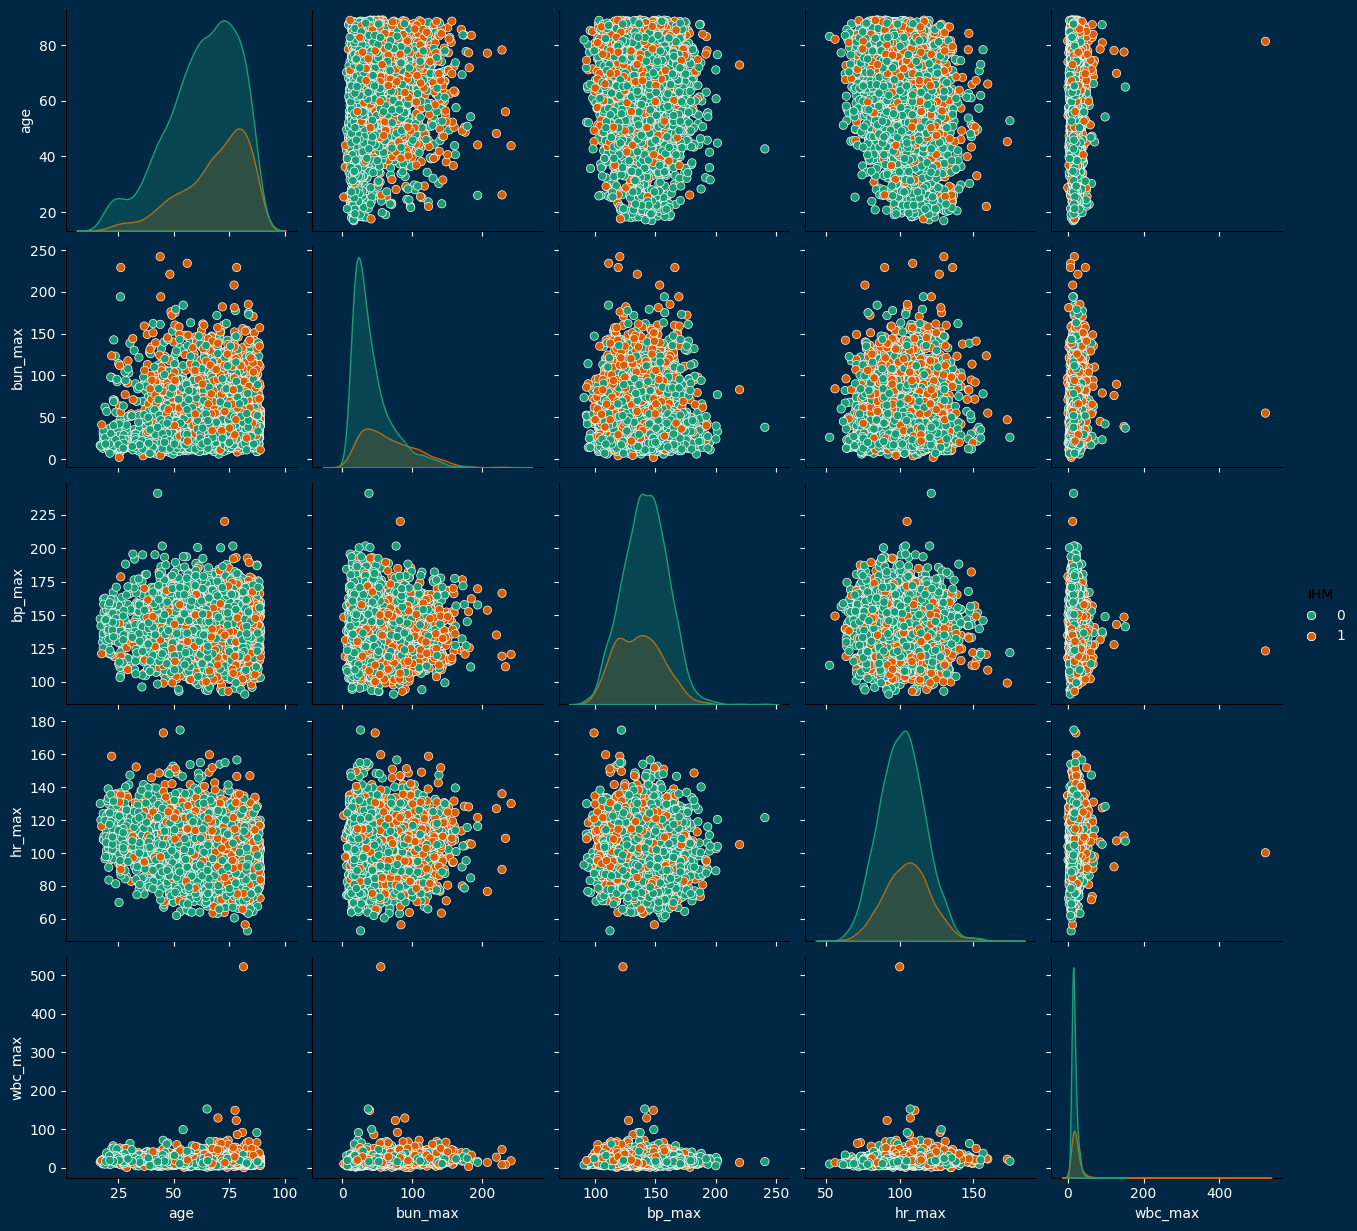

In [ ]:
g= sns.pairplot(df, hue='IHM', vars=['age', 'bun_max', 'bp_max', 'hr_max', 'wbc_max'], palette="Dark2")
g.fig.set_facecolor('#002845')
for ax in g.axes.flatten():
    ax.set_facecolor('#002845')
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')

# Customize the legend
g.add_legend()
legend = g._legend
legend.get_frame().set_facecolor('#002845')
legend.get_frame().set_edgecolor('white')
for text in legend.get_texts():
    text.set_color('white')

plt.show()



Most variables show weak or no strong linear correlations, as evident from the scattered points in the off-diagonal plots. The diagonal plots highlight the distributions, where variables like Age are skewed toward younger participants, and WBC_max shows significant outliers. The color-coded groups (IHM = 0 and 1) suggest that certain variables, such as HR_max and WBC_max, may provide some separation between the two groups, potentially indicating their relevance for classification. However, other variables like BP_max and Age do not exhibit clear distinctions between the groups, hinting at weaker predictive value for these features. Overall, the data suggests further analysis is needed, particularly focusing on outliers and identifying which variables are most influential for distinguishing between the two IHM groups.

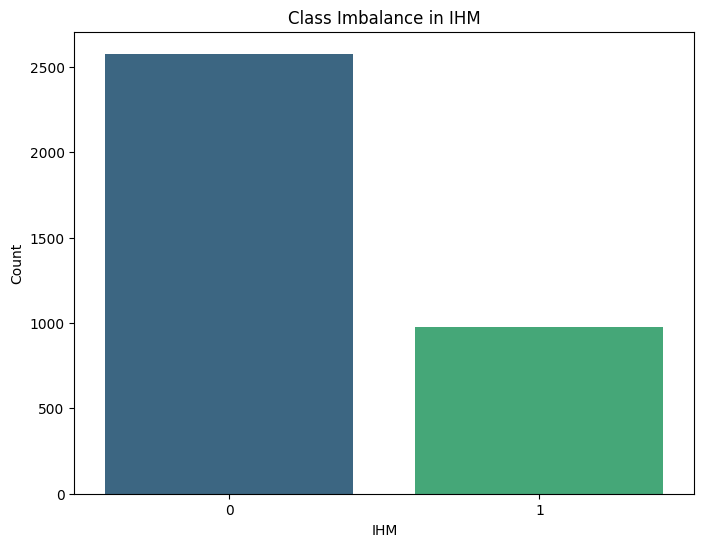

In [ ]:
# Plot class distribution in 'IHM'
plt.figure(figsize=(8, 6))
sns.countplot(x='IHM', data=df, palette="viridis")

plt.title("Class Imbalance in IHM")
plt.xlabel('IHM')
plt.ylabel('Count')

plt.show()


The bar plot illustrates a significant class imbalance in the HMI variable. The majority of observations belong to the class 0, while the class 1 is significantly underrepresented. This imbalance can potentially affect the performance of machine learning models, as they may become biased towards the majority class. To address this issue, techniques like oversampling, undersampling, or using appropriate loss functions can be employed to improve model performance

## **Data Preparation Steps:**

1. Data Validation:Check for impossible values and validates ranges for clinical measurements
2. Check for outliers and deal with them if they're present
3. Standardizes all numerical features
4. Handle Missing Values
5. Handle class imbalance
6. Feature Engineer new columns

We adopted a class based approach for the preprocessing phase so as to bundle together all the steps listed above. This facilitated faster experimentations with different preprocessing pipelines


In [ ]:
class Preprocessor():
    def __init__(self, handle_outliers='clip', imbalance_strategy='oversample'):
        self.numerical_columns = [
            'age', 'bic_max', 'bic_mean', 'bic_min',
            'bilirubin', 'bp_max', 'bp_mean', 'bp_min',
            'bun_max', 'bun_mean', 'bun_min', 'Days_in_uci',
            'fio2', 'gcs_max', 'gcs_mean', 'gcs_min',
            'hr_max', 'hr_mean', 'hr_min',
            'max pao2', 'mean pao2', 'min pao2',
            'pot_max', 'pot_mean', 'pot_min',
            'sod_max', 'sod_mean', 'sod_min',
            'temp', 'wbc_max', 'wbc_mean', 'wbc_min'
        ]

        self.categorical_columns = ['gender_F', 'gender_M']
        self.outcome_column = 'IHM'
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')
        self.handle_outliers = handle_outliers
        self.imbalance_strategy = imbalance_strategy
        self.clinical_ranges = {
                              'temp': (25, 43),  # Celsius
                              'hr_mean': (20, 200),  # beats per minute
                              'bp_mean': (40, 250),  # mmHg
                              'gcs_mean': (3, 15),  # Glasgow Coma Scale
                              'bilirubin': (0, 30),  # mg/dL
                              'wbc_mean': (0, 100)  # x10^9/L
                          }

    def detect_outliers(self, X):
        """Detect outliers using clinical ranges and statistical methods."""
        outliers = pd.DataFrame(index=X.index)

        for col, (low, high) in self.clinical_ranges.items():
            if col in X.columns:
                outliers[f'{col}_outlier'] = ~X[col].between(low, high)

        for col in self.numerical_columns:
            if col not in self.clinical_ranges and col in X.columns:
                mean, std = X[col].mean(), X[col].std()
                outliers[f'{col}_outlier'] = ~X[col].between(mean - 3*std, mean + 3*std)

        return outliers

    def handle_outliers_in_data(self, X):
        """Handle outliers based on the chosen strategy."""
        outliers = self.detect_outliers(X)
        for col in self.numerical_columns:
            if col in X.columns:
                if self.handle_outliers == 'clip':
                    if col in self.clinical_ranges:
                        X[col] = X[col].clip(*self.clinical_ranges[col])
                    else:
                        mean, std = X[col].mean(), X[col].std()
                        X[col] = X[col].clip(mean - 3 * std, mean + 3 * std)
                elif self.handle_outliers == 'impute':
                    X.loc[outliers[f'{col}_outlier'], col] = np.nan
        # Ensure all NaNs are imputed
        X[self.numerical_columns] = pd.DataFrame(
            self.imputer.fit_transform(X[self.numerical_columns]),
            columns=self.numerical_columns,
            index=X.index
        )
        return X


    def balance_classes(self, X, y):
        """Handle class imbalance."""
        if self.imbalance_strategy == 'oversample':
            smote = SMOTE(random_state=42)
            X, y = smote.fit_resample(X, y)
        elif self.imbalance_strategy == 'undersample':
            class_counts = y.value_counts()
            majority_class = class_counts.idxmax()
            minority_class = class_counts.idxmin()
            majority_size = class_counts[minority_class]
            majority_indices = y[y == majority_class].sample(majority_size, random_state=42).index
            minority_indices = y[y == minority_class].index
            balanced_indices = np.concatenate([majority_indices, minority_indices])
            X = X.loc[balanced_indices]
            y = y.loc[balanced_indices]
        return X, y

    def create_derived_features(self, X):
        """Create clinically relevant derived features"""
        derived = pd.DataFrame(index=X.index)

        # PaO2/FiO2 ratio (important for respiratory function)
        if all(col in X.columns for col in ['mean pao2', 'fio2']):
            derived['pf_ratio'] = X['mean pao2'] / (X['fio2'] / 100)

        # Mean Arterial Pressure
        if all(col in X.columns for col in ['bp_max', 'bp_min']):
            derived['map'] = ((2 * X['bp_min']) + X['bp_max']) / 3

        # Variability measures for key vital signs
        vital_signs = ['hr', 'bp', 'temp']
        for vs in vital_signs:
            max_col, min_col = f'{vs}_max', f'{vs}_min'
            if max_col in X.columns and min_col in X.columns:
                derived[f'{vs}_variability'] = X[max_col] - X[min_col]

        return derived

    def fit(self, X, y=None):
        """Fit the preprocessor."""
        X = self.handle_outliers_in_data(X)
        self.scaler.fit(X[self.numerical_columns])
        if y is not None:
            self.class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
        return self

    def transform(self, X):
        """Transform the data."""
        X = self.handle_outliers_in_data(X)
        X_transformed = X.copy()
        X_transformed[self.numerical_columns] = self.scaler.transform(X_transformed[self.numerical_columns])
        derived_features = self.create_derived_features(X)
        X_transformed = pd.concat([X_transformed, derived_features], axis=1)
        return X_transformed

    def fit_transform(self, X, y=None):
        """Fit and transform the data."""
        self.fit(X, y)
        if y is not None and self.imbalance_strategy:
            X, y = self.balance_classes(X, y)
        return self.transform(X), y

    def preprocess_and_clean(self, X, y):
        """
        Preprocess data and return a cleaned dataframe.
        Combines feature engineering, outlier handling, scaling, and class balancing.
        """
        X_transformed, y_balanced = self.fit_transform(X, y)
        cleaned_df = pd.DataFrame(X_transformed, columns=X.columns)
        cleaned_df[self.outcome_column] = y_balanced
        return cleaned_df


### **Justification for Preprocessing Steps**
---

### 1. Handling Missing Data
- The use of a **median imputation strategy** ensures that missing values are filled with a robust central tendency measure, minimizing distortion in skewed distributions common in clinical data.

---

### 2. Outlier Detection and Handling
- ICU patients, especially those with AKI, exhibit extreme physiological measurements due to critical illness. Some of these may be **true outliers** (e.g., critically high blood pressure), while others could be **artifacts of data entry or device error**.
- **Clinical ranges** (e.g., Glasgow Coma Scale of 3-15) ensure that values are biologically plausible, grounded in domain knowledge.
- Statistical thresholds (`mean ± 3*std`) for less clinically defined variables catch unusual values that could skew model performance.

---

## 3. Class Balancing
- In-hospital mortality is **imbalanced** in this dataset, with significantly fewer patients dying compared to surviving. Such imbalance can:
  - Lead to biased models that favor the majority class (survivors).
  - Undermine the prediction of mortality (minority class), the objective of this analysis.
- **SMOTE** (oversampling) is applied to synthetically generate minority class samples, creating a balanced dataset without discarding valuable data.

---

## 4. Scaling Numerical Features
- **StandardScaler** ensures all features are standardized to have a mean of 0 and a standard deviation of 1, making the dataset uniform and improving model convergence.

---

## 5. Feature Engineering
Derived features are created to include clinically meaningful indicators:
- **PaO2/FiO2 ratio**: This ratio assesses oxygenation efficiency and is crucial for evaluating respiratory failure, a common complication in ICU patients with AKI.
- **Mean Arterial Pressure (MAP)**: MAP is a key metric for hemodynamic stability, crucial for understanding patient outcomes in critically ill populations.
- **Variability metrics** for heart rate, blood pressure, and temperature: Variations in these parameters often signal instability or deteriorating conditions, directly tied to mortality risk.

---

## 6. Outlier Handling via Clipping or Imputation
- **Clipping**: For features with defined clinical ranges, extreme values are clipped to prevent model distortion while retaining valid data.
- **Imputation**: Replaces biologically implausible or extreme values with `NaN` to be imputed later, preventing noise from skewing the dataset.

---


In [ ]:
## Change these back to int
df['gender_F'] = df['gender_F'].astype(int)
df['gender_M'] = df['gender_M'].astype(int)

In [ ]:
X = df.drop(columns=['IHM'])
y = df['IHM']

preprocessor = Preprocessor(handle_outliers='clip', imbalance_strategy='oversample')
cleaned_df = preprocessor.preprocess_and_clean(X, y)
cleaned_df.head()


,age,gender_F,gender_M,bic_max,bic_mean,bic_min,bilirubin,bp_max,bp_mean,bp_min,...,pot_mean,pot_min,sod_max,sod_mean,sod_min,temp,wbc_max,wbc_mean,wbc_min,IHM
0,0.647093,1,0,2.002521,2.205992,2.104124,-0.354778,0.782527,0.037213,-0.553835,...,-0.666541,-0.600661,-0.176505,0.513279,0.971421,-0.001716,-0.565813,-0.563098,-0.455421,0
1,-0.260668,1,0,0.796359,0.818158,0.719291,-0.424201,-1.457396,-1.232771,-0.918004,...,-0.974513,-2.348008,0.144095,0.433374,0.971421,1.410437,0.324184,0.899295,1.696437,0
2,-0.010424,1,0,-0.811856,-0.371764,0.026875,-0.389489,-0.728922,-0.943952,-2.196001,...,-0.632322,0.034738,0.144095,0.336936,0.734187,-0.001716,1.799705,1.192118,0.647406,0
3,-0.614764,0,1,0.796359,1.316605,1.180902,-0.146507,0.607153,-0.570468,-0.665887,...,0.428473,0.352438,0.678429,0.218456,0.022485,-0.075393,1.225892,0.122452,-1.504452,1
4,0.871687,0,1,-0.088159,-0.608771,-0.665542,-0.146507,1.410094,1.494282,1.400258,...,0.188939,-0.282961,1.266196,0.436129,0.378336,-0.001716,3.063877,-0.652668,-2.096213,1


### **Preprocessing Pipeline for Experimentation**

The implementation builds on previous preprocessing efforts by introducing a modular pipeline to systematically evaluate and optimize machine learning models for predicting in-hospital mortality (IHM) in ICU patients with Acute Kidney Injury (AKI). It explores various preprocessing techniques, feature engineering methods, and model configurations to identify the optimal combination for the task.

---

### Key Features

1. **Experimentation Pipeline**
   - Systematically tests combinations of:
      - **Scaling Strategies:**
        - **StandardScaler:** Standardizes features by removing the mean and scaling to unit variance.
        - **RobustScaler:** Scales features using the median and interquartile range, reducing sensitivity to outliers.
        - **MinMaxScaler:** Transforms features to a specified range (default: 0 to 1) by scaling each feature proportionally.

      - **Imputation Strategies:**
        - **Median:** Replaces missing values with the median of each feature.
        - **Mean:** Replaces missing values with the mean of each feature.
        - **KNN-based:** Uses the k-nearest neighbors to estimate and fill missing values based on feature similarity.

      - **Outlier Handling:**
        - **Clinical Clipping:** Clips values to clinically valid ranges for medical variables.
        - **Statistical Clipping:** Caps values within a specified range using the mean ± threshold × standard deviation.
        - **Outlier Removal:** Replaces outliers with NaN, allowing them to be handled by the imputation strategy.

      - **Balancing Strategies:**
        - **SMOTE (Synthetic Minority Oversampling Technique):** Generates synthetic samples for the minority class to balance the dataset.
        - **ADASYN (Adaptive Synthetic Sampling Approach for Imbalanced Learning):** Similar to SMOTE but focuses more on difficult-to-learn examples in the minority class.
        - **Undersampling:** Reduces the size of the majority class by randomly removing samples.
        - **SMOTEENN:** Combines SMOTE with Edited Nearest Neighbors to oversample the minority class and clean the majority class.

   - Evaluates machine learning models
   - Reports key performance metrics:
     - F1-Score, and Area Under the Curve (AUC).

---

### Benefits
This modular and systematic approach enhances:
- **Flexibility:** Ability to test multiple configurations with minimal manual intervention.
- **Reusability:** Modular design supports integration into similar prediction tasks.
- **Optimization:** Identifies preprocessing and model configurations that maximize predictive performance.


In [ ]:
class ModularPreprocessor():
    def __init__(
        self,
        scaling_strategy='standard',
        imputation_strategy='median',
        outlier_strategy='clip',
        balancing_strategy='smote',
        feature_engineering=True,
        outlier_threshold=3,
        knn_neighbors=5
    ):
        self.scaling_strategy = scaling_strategy
        self.imputation_strategy = imputation_strategy
        self.outlier_strategy = outlier_strategy
        self.balancing_strategy = balancing_strategy
        self.feature_engineering = feature_engineering
        self.outlier_threshold = outlier_threshold
        self.knn_neighbors = knn_neighbors

        self.numerical_columns = [
            'age', 'bic_max', 'bic_mean', 'bic_min',
            'bilirubin', 'bp_max', 'bp_mean', 'bp_min',
            'bun_max', 'bun_mean', 'bun_min', 'Days_in_uci',
            'fio2', 'gcs_max', 'gcs_mean', 'gcs_min',
            'hr_max', 'hr_mean', 'hr_min',
            'max pao2', 'mean pao2', 'min pao2',
            'pot_max', 'pot_mean', 'pot_min',
            'sod_max', 'sod_mean', 'sod_min',
            'temp', 'wbc_max', 'wbc_mean', 'wbc_min'
        ]
        self.categorical_columns = ['gender_F', 'gender_M']

        # Clinical ranges for validation
        self.clinical_ranges = {
            'temp': (25, 43),
            'hr_mean': (20, 200),
            'bp_mean': (40, 250),
            'gcs_mean': (3, 15),
            'bilirubin': (0, 30),
            'wbc_mean': (0, 100)
        }

        # Initialize components based on strategies
        self._initialize_components()

    def _initialize_components(self):
        # Initialize scaler
        if self.scaling_strategy == 'standard':
            self.scaler = StandardScaler()
        elif self.scaling_strategy == 'robust':
            self.scaler = RobustScaler()
        elif self.scaling_strategy == 'minmax':
            self.scaler = MinMaxScaler()

        # Initialize imputer
        if self.imputation_strategy == 'median':
            self.imputer = SimpleImputer(strategy='median')
        elif self.imputation_strategy == 'mean':
            self.imputer = SimpleImputer(strategy='mean')
        elif self.imputation_strategy == 'knn':
            self.imputer = KNNImputer(n_neighbors=self.knn_neighbors)

        # Initialize balancing method
        if self.balancing_strategy == 'smote':
            self.balancer = SMOTE(random_state=42)
        elif self.balancing_strategy == 'adasyn':
            self.balancer = ADASYN(random_state=42)
        elif self.balancing_strategy == 'undersample':
            self.balancer = RandomUnderSampler(random_state=42)
        elif self.balancing_strategy == 'smoteenn':
            self.balancer = SMOTEENN(random_state=42)
        elif self.balancing_strategy == 'smotetomek':
            self.balancer = SMOTETomek(random_state=42)

    def _handle_outliers(self, X):
        X_copy = X.copy()

        if self.outlier_strategy == 'clip':
            # Clinical range clipping
            for col, (low, high) in self.clinical_ranges.items():
                if col in X_copy.columns:
                    X_copy[col] = X_copy[col].clip(low, high)

            # Statistical clipping for other columns
            for col in self.numerical_columns:
                if col not in self.clinical_ranges and col in X_copy.columns:
                    mean, std = X_copy[col].mean(), X_copy[col].std()
                    X_copy[col] = X_copy[col].clip(
                        mean - self.outlier_threshold * std,
                        mean + self.outlier_threshold * std
                    )

        elif self.outlier_strategy == 'remove':
            for col in self.numerical_columns:
                if col in X_copy.columns:
                    mean, std = X_copy[col].mean(), X_copy[col].std()
                    mask = X_copy[col].between(
                        mean - self.outlier_threshold * std,
                        mean + self.outlier_threshold * std
                    )
                    X_copy.loc[~mask, col] = np.nan

        return X_copy

    def _engineer_features(self, X):
        if not self.feature_engineering:
            return X

        X_copy = X.copy()

        # PaO2/FiO2 ratio
        if all(col in X_copy.columns for col in ['mean pao2', 'fio2']):
            X_copy['pf_ratio'] = X_copy['mean pao2'] / (X_copy['fio2'] / 100)

        # Mean Arterial Pressure
        if all(col in X_copy.columns for col in ['bp_max', 'bp_min']):
            X_copy['map'] = ((2 * X_copy['bp_min']) + X_copy['bp_max']) / 3

        # Vital signs variability
        for vs in ['hr', 'bp', 'wbc', 'bun', 'bic', 'pot', 'sod']:
            max_col, min_col = f'{vs}_max', f'{vs}_min'
            if max_col in X_copy.columns and min_col in X_copy.columns:
                X_copy[f'{vs}_variability'] = X_copy[max_col] - X_copy[min_col]
                X_copy[f'{vs}_variability_pct'] = (
                    (X_copy[max_col] - X_copy[min_col]) / X_copy[f'{vs}_mean']
                ) * 100


    def fit(self, X, y=None):
        X_cleaned = self._handle_outliers(X)

        X_engineered = self._engineer_features(X_cleaned)

        self.numerical_columns = [
            col for col in X_engineered.columns
            if col not in self.categorical_columns
        ]

        self.imputer.fit(X_engineered[self.numerical_columns])

        X_imputed = pd.DataFrame(
            self.imputer.transform(X_engineered[self.numerical_columns]),
            columns=self.numerical_columns,
            index=X_engineered.index
        )
        self.scaler.fit(X_imputed)

        return self

    def transform(self, X):
        X_cleaned = self._handle_outliers(X)

        X_engineered = self._engineer_features(X_cleaned)

        X_imputed = pd.DataFrame(
            self.imputer.transform(X_engineered[self.numerical_columns]),
            columns=self.numerical_columns,
            index=X_engineered.index
        )

        X_scaled = pd.DataFrame(
            self.scaler.transform(X_imputed),
            columns=self.numerical_columns,
            index=X_engineered.index
        )

        for col in self.categorical_columns:
            if col in X_engineered.columns:
                X_scaled[col] = X_engineered[col]

        return X_scaled

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        X_transformed = self.transform(X)

        if y is not None and self.balancing_strategy:
            X_transformed, y = self.balancer.fit_resample(X_transformed, y)

        return X_transformed, y



In [ ]:
def experiment_with_pipelines(X, y, models, param_grid, cv=5):
    results = []

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    for scaling in param_grid['scaling_strategy']:
        for imputation in param_grid['imputation_strategy']:
            for outlier in param_grid['outlier_strategy']:
                for balancing in param_grid['balancing_strategy']:
                    for model_name, model in models.items():
                        try:
                            preprocessor = ModularPreprocessor(
                                scaling_strategy=scaling,
                                imputation_strategy=imputation,
                                outlier_strategy=outlier,
                                balancing_strategy=balancing
                            )

                            X_train_processed, y_train_balanced = preprocessor.fit_transform(
                                X_train, y_train
                            )
                            X_test_processed = preprocessor.transform(X_test)

                            model.fit(X_train_processed, y_train_balanced)
                            y_pred = model.predict(X_test_processed)

                            report = classification_report(y_test, y_pred, output_dict=True)
                            auc = roc_auc_score(y_test, model.predict_proba(X_test_processed)[:, 1])

                            results.append({
                                'model': model_name,
                                'scaling': scaling,
                                'imputation': imputation,
                                'outlier_handling': outlier,
                                'balancing': balancing,
                                'f1': report['weighted avg']['f1-score'],
                                'auc': auc
                            })

                        except Exception as e:
                            print(f"Error with configuration: {scaling}, {imputation}, "
                                  f"{outlier}, {balancing}, {model_name}")
                            print(f"Error message: {str(e)}")
                            continue

    return pd.DataFrame(results)

## **Modeling**

In [ ]:
# # Data splitting
data = cleaned_df.copy()
X = data.drop(columns=['IHM'])
y = data['IHM']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### **Ensemble Models**

In [ ]:
#Ensemble Models as base model
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'Gradient Boosting': {'n_estimators': [50, 100], 'learning_rate': [0.1, 0.01]},
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.01],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0]
    }
}


results = []

for model_name, model in models.items():
    grid = GridSearchCV(model, param_grids[model_name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict_proba(X_val)[:, 1]
    results.append({
        'Model': model_name,
        'AUC-ROC': roc_auc_score(y_val, y_pred),
        'F1-Score': f1_score(y_val, (y_pred > 0.5).astype(int)),
        'Best Params': grid.best_params_
    })

ensemble_results = pd.DataFrame(results)
ensemble_results.sort_values(by='AUC-ROC', ascending=False)

,Model,AUC-ROC,F1-Score,Best Params
3,XGBoost,0.960589,0.894837,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."
0,Random Forest,0.956984,0.886578,"{'max_depth': 20, 'n_estimators': 200}"
1,Gradient Boosting,0.941236,0.872832,"{'learning_rate': 0.1, 'n_estimators': 100}"
2,Logistic Regression,0.927474,0.855741,{'C': 10}


#### Perform Regularization

In [ ]:
# Initialize the baseline XGBoost model (no regularization)
xgb_model_baseline = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the baseline model
xgb_model_baseline.fit(X_train, y_train)

# Make predictions
train_preds_baseline = xgb_model_baseline.predict(X_train)
test_preds_baseline = xgb_model_baseline.predict(X_val)

# Evaluate probabilities for ROC-AUC
train_probs_baseline = xgb_model_baseline.predict_proba(X_train)[:, 1]
test_probs_baseline = xgb_model_baseline.predict_proba(X_val)[:, 1]

# Compute metrics
train_f1_baseline = f1_score(y_train, train_preds_baseline)
test_f1_baseline = f1_score(y_val, test_preds_baseline)

train_auc_baseline = roc_auc_score(y_train, train_probs_baseline)
test_auc_baseline = roc_auc_score(y_val, test_probs_baseline)

print("Baseline XGBoost (No Regularization)")
print(f"Train F1-Score: {train_f1_baseline:.4f}")
print(f"Test F1-Score: {test_f1_baseline:.4f}")
print(f"Train AUC-ROC: {train_auc_baseline:.4f}")
print(f"Test AUC-ROC: {test_auc_baseline:.4f}")


Baseline XGBoost (No Regularization)
Train F1-Score: 0.9228
Test F1-Score: 0.8833
Train AUC-ROC: 0.9797
Test AUC-ROC: 0.9562


In [ ]:
# Initialize XGBoost with L1 and L2 regularization

xgb_model_regularized = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    lambda_=1,  # L2 regularization strength
    alpha=0.8,  # L1 regularization strength
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Train the model
xgb_model_regularized.fit(X_train, y_train)

# Make predictions
train_preds = xgb_model_regularized.predict(X_train)
test_preds = xgb_model_regularized.predict(X_val)

# Evaluate probabilities for ROC-AUC
train_probs = xgb_model_regularized.predict_proba(X_train)[:, 1]
test_probs = xgb_model_regularized.predict_proba(X_val)[:, 1]

# Compute metrics
train_f1 = f1_score(y_train, train_preds)
test_f1 = f1_score(y_val, test_preds)

train_auc = roc_auc_score(y_train, train_probs)
test_auc = roc_auc_score(y_val, test_probs)

print("XGBoost with Regularization")
print(f"Train F1-Score: {train_f1:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Train AUC-ROC: {train_auc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")


XGBoost with Regularization
Train F1-Score: 0.9200
Test F1-Score: 0.8860
Train AUC-ROC: 0.9789
Test AUC-ROC: 0.9571


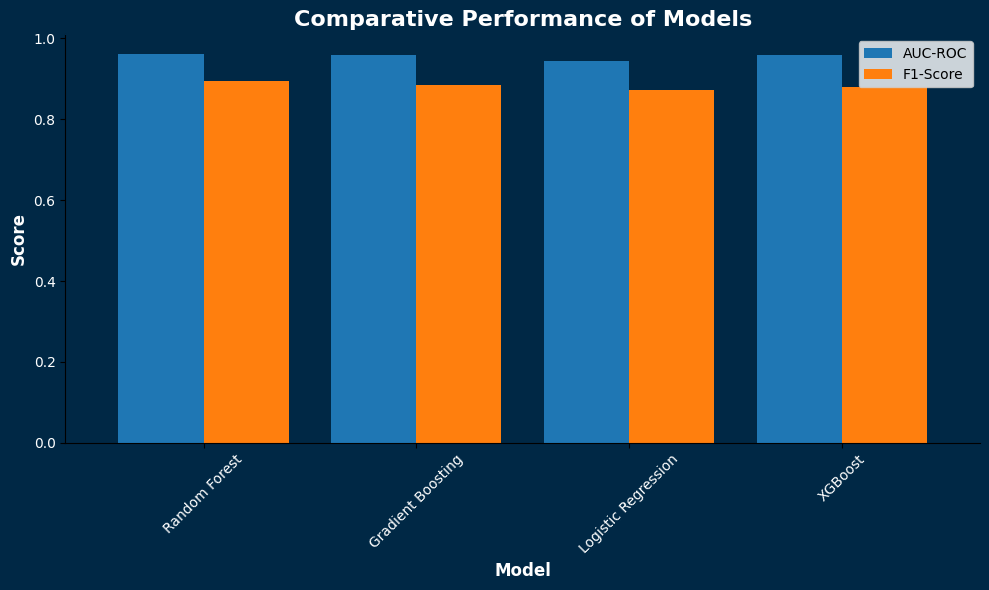

In [ ]:
# Create the figure with the background color set to #002845
fig, ax = plt.subplots(figsize=(10, 6), facecolor='#002845')

# Plot the bar chart with AUC-ROC and F1-Score, no scaling
ensemble_results.set_index('Model')[['AUC-ROC', 'F1-Score']].plot(kind='bar',
                                                                  color=['#1f77b4', '#ff7f0e'],
                                                                  width=0.8, ax=ax)

# Set the background color of the entire axes area (plot + model names)
ax.set_facecolor('#002845')

# Set plot labels and title with white text for visibility
plt.title('Comparative Performance of Models', fontsize=16, color='white', fontweight='bold')
plt.xlabel('Model', fontsize=12, color='white', fontweight='bold')
plt.ylabel('Score', fontsize=12, color='white', fontweight='bold')

# Adjust tick labels to be white for contrast against the background
plt.xticks(rotation=45, color='white')

plt.yticks(color='white')

# Set the color of the axis lines (spines) to green
ax.spines['top'].set_color('#002845')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('#002845')

# Set gridlines (optional for better readability), color them white for contrast
#ax.grid(True, axis='y', linestyle='--', linewidth=0.7, color='white', alpha=0.5)


plt.tight_layout()

plt.show()


#### **Justification for using the above ensemble models as base models**

#### **Random Forest**  
Random Forest is an ensemble learning method that uses the bagging technique to combine multiple decision trees. Each tree is built using a random subset of the data and features, reducing overfitting and improving generalization. This approach makes Random Forest robust to noise and capable of handling missing data effectively.

Its ability to model complex, non-linear relationships is valuable for predicting in-hospital mortality, where patient health trajectories are highly variable. Additionally, Random Forest provides feature importance scores, enabling insights into which clinical factors most influence the outcome.

---

#### **Gradient Boosting**  
Gradient Boosting is a boosting algorithm that builds models sequentially, each one correcting the errors of its predecessor. By combining weak learners (typically shallow trees), it creates a powerful predictive model.

Gradient Boosting is known for its high predictive accuracy and ability to capture intricate patterns in data. It is particularly suitable for this task due to its flexibility in adjusting hyperparameters, such as learning rate and tree depth, which help balance the trade-off between bias and variance.

This capability is crucial for accurately predicting mortality, where small changes in features can have significant impacts on outcomes.

---

#### **Logistic Regression**  
Logistic Regression is a simple yet effective linear model used for binary classification problems. It estimates the probability of the target variable (e.g., mortality) based on a linear combination of input features.

Logistic Regression is computationally efficient and interpretable, providing insights into the relationship between predictors and the target variable. For this project, it serves as a baseline model to evaluate the improvements offered by more complex models. Its inherent simplicity makes it an essential tool for understanding the data before delving into non-linear methods.

---

#### **XGBoost (Extreme Gradient Boosting)**  
XGBoost is an advanced implementation of Gradient Boosting that incorporates regularization techniques (L1 and L2) to prevent overfitting and improve generalization.

It is highly efficient due to features like tree pruning, parallelization, and built-in handling of missing values. XGBoost excels in capturing complex interactions between features, making it particularly useful for clinical datasets with diverse and non-linear patterns.

Its scalability and flexibility in hyperparameter tuning make it a strong candidate for this task, as it balances speed, accuracy, and interpretability effectively.

---

### **Deep Learning**

In [ ]:
# Define a function that create models with various architectures

def create_model(optimizer='adam', dropout_rate=0.0, units=64, architecture='simple'):
    model = Sequential()

    if architecture == 'simple':  # Single hidden layer
        model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

    elif architecture == 'deep':  # Two hidden layers
        model.add(Dense(units, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units // 2, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

    elif architecture == 'wider':  # Wider hidden layer
        model.add(Dense(units * 2, activation='relu', input_dim=X_train.shape[1]))
        model.add(Dropout(dropout_rate))
        model.add(Dense(units, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['AUC'])
    return model


In [ ]:
# Define a function to evaluate the models
def train_evaluate_model(params):
    model = create_model(
        optimizer=params['optimizer'],
        dropout_rate=params['dropout_rate'],
        units=params['units'],
        architecture=params['architecture']
    )
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=params['epochs'], batch_size=params['batch_size'],
        verbose=0
    )
    y_pred = (model.predict(X_val) > 0.5).astype(int)
    auc_roc = roc_auc_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    return model, auc_roc, f1


#### **Grid search for hyperparameter tuning**

In [ ]:
# A dictionary with various parameters for experimentation
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'dropout_rate': [0.0, 0.3],
    'units': [64, 128],
    'batch_size': [32, 64],
    'epochs': [50, 100],
    'architecture': ['simple', 'deep', 'wider']}


In [ ]:
# Initialize search
results = []

# Grid Search
for params in itertools.product(*param_grid.values()):
    params_dict = dict(zip(param_grid.keys(), params))
    print(f"Training with params: {params_dict}")
    model, auc_roc, f1 = train_evaluate_model(params_dict)
    results.append({
        'params': params_dict,
        'AUC-ROC': auc_roc,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='AUC-ROC', ascending=False))

Training with params: {'optimizer': 'adam', 'dropout_rate': 0.0, 'units': 64, 'batch_size': 32, 'epochs': 50, 'architecture': 'simple'}
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training with params: {'optimizer': 'adam', 'dropout_rate': 0.0, 'units': 64, 'batch_size': 32, 'epochs': 50, 'architecture': 'deep'}
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training with params: {'optimizer': 'adam', 'dropout_rate': 0.0, 'units': 64, 'batch_size': 32, 'epochs': 50, 'architecture': 'wider'}
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training with params: {'optimizer': 'adam', 'dropout_rate': 0.0, 'units': 64, 'batch_size': 32, 'epochs': 100, 'architecture': 'simple'}
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training with params: {'optimizer': 'adam', 'dropout_rate': 0.0, 'units': 64, 'batch_size': 32, 'epochs': 100, 'architecture': 'deep'}
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training with params: {'optimizer': 'adam', 'dropout_rate': 0.0, 'units': 64, 'batch_size': 32, 'epochs': 100, 'architecture': '

In [ ]:
# Select the best hyperparameters based on AUC-ROC
best_params = results_df.sort_values(by='AUC-ROC', ascending=False).iloc[0]['params']
print(f"Best Parameters: {best_params}")

# Retrain the best model
best_model, _, _ = train_evaluate_model(best_params)

Best Parameters: {'optimizer': 'adam', 'dropout_rate': 0.3, 'units': 128, 'batch_size': 64, 'epochs': 100, 'architecture': 'wider'}
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Best parameters
best_params = {
    'optimizer': 'adam',
    'dropout_rate': 0.3,
    'units': 128,
    'batch_size': 32,
    'epochs': 100,
    'architecture': 'wider'
}

# Create and train the model with the best parameters
model = create_model(
    optimizer=best_params['optimizer'],
    dropout_rate=best_params['dropout_rate'],
    units=best_params['units'],
    architecture=best_params['architecture']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

# Make predictions
train_probs = model.predict(X_train).ravel()
test_probs = model.predict(X_val).ravel()

# Convert probabilities to binary predictions for F1-Score
train_preds = (train_probs > 0.5).astype(int)
test_preds = (test_probs > 0.5).astype(int)

# Evaluate metrics
train_auc = roc_auc_score(y_train, train_probs)
test_auc = roc_auc_score(y_val, test_probs)

train_f1 = f1_score(y_train, train_preds)
test_f1 = f1_score(y_val, test_preds)

# Print results
print("Deep Learning Model Evaluation with Best Parameters")
print(f"Train AUC-ROC: {train_auc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - AUC: 0.8325 - loss: 0.5012 - val_AUC: 0.9241 - val_loss: 0.3563
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9156 - loss: 0.3701 - val_AUC: 0.9257 - val_loss: 0.3512
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9310 - loss: 0.3369 - val_AUC: 0.9315 - val_loss: 0.3440
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9368 - loss: 0.3223 - val_AUC: 0.9361 - val_loss: 0.3375
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9480 - loss: 0.2940 - val_AUC: 0.9349 - val_loss: 0.3312
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9548 - loss: 0.2728 - val_AUC: 0.9371 - val_loss: 0.3217
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9557 - loss: 0.2728 - val_AUC: 0.9343 - val_loss: 0.3351
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9575 - loss: 0.2646 - val_AUC: 0.9404 - val_loss: 0.3176
Epoch 9/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

### **Justification for using Deep Learning in this project**

#### **1. Ability to Model Complex Non-Linear Relationships**  
Deep learning excels at modeling complex, non-linear relationships between features, which are common in medical datasets like the one used in this project. Clinical variables such as blood pressure, heart rate, and oxygen levels often interact in ways that are not straightforward or easily captured by traditional linear models like logistic regression. Deep learning neural networks, with their multiple layers and non-linear activation functions, can uncover these intricate patterns and relationships, providing a more accurate representation of how these factors contribute to in-hospital mortality. This capability is crucial when predicting outcomes where small variations in input features can lead to significant differences in patient outcomes.

---

#### **2. Scalability to Large Datasets and High Dimensionality**  
The dataset for this project, derived from the MIMIC-III database, is both extensive and high-dimensional, containing numerous clinical features that summarize a patient’s trajectory in the ICU. Deep learning models are uniquely suited to leverage large datasets, as their performance tends to improve with increasing data size, unlike traditional machine learning models that often plateau in performance. Moreover, deep learning automatically learns hierarchical feature representations, reducing the need for manual feature engineering. In the context of this project, the large-scale nature of the data provides an ideal foundation for neural networks to capture nuanced patterns and make reliable predictions.

---

#### **3. Robustness and Regularization Techniques for Generalization**  
Overfitting is a common concern when building predictive models, especially for complex tasks like mortality prediction in ICU patients. Deep learning incorporates advanced regularization techniques, such as dropout layers, weight regularization (L2), and early stopping, which help prevent overfitting and improve generalization to new data. These techniques ensure that the model does not merely memorize the training data but instead learns patterns that generalize well to unseen examples. For this project, where the ultimate test data is withheld for final evaluation, the use of such regularization methods in deep learning enhances the likelihood of achieving consistent and reliable performance.

---

#### **4. Superior Performance in Healthcare Applications**  
Deep learning has consistently demonstrated superior performance in healthcare-related tasks, including ICU outcome predictions, disease diagnosis, and time-series analysis of medical data. Research has shown that neural networks often outperform traditional models like random forests and logistic regression in predicting outcomes where patterns are highly complex and datasets are large. In the context of this project, the task of predicting mortality involves a binary classification problem where deep learning can leverage its ability to minimize binary cross-entropy loss and optimize metrics like AUC-ROC. The ability to achieve higher accuracy and better precision-recall balance validates its use in critical applications like in-hospital mortality prediction.

---



#### **Best Models Results**

**Baseline Ensemble model**

xgb_model_regularized = XGBClassifier(

    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    lambda_=1,  # L2 regularization strength
    alpha=0.8,  # L1 regularization strength
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

**Deep Learning Model**

{'optimizer': 'adam', 'dropout_rate': 0.3, 'units': 128, 'batch_size': 64, 'epochs': 100, 'architecture': 'wider'}

### **Models Stacking**

Next step we stack both the ensemble model and the deeplearning model to improve performance

In [ ]:
# Convert data to NumPy for compatibility
X_train_np = X_train.to_numpy() if hasattr(X_train, "to_numpy") else X_train
y_train_np = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
X_val_np = X_val.to_numpy() if hasattr(X_val, "to_numpy") else X_val

# Base Models
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    lambda_=1,
    alpha=0.8,
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

def create_dl_model(input_dim):
    """Create a deep learning model."""
    model = Sequential([
        Dense(128 * 2, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    return model

# Meta-Model
meta_model = LogisticRegression()

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize storage for predictions
train_meta_features = np.zeros((X_train_np.shape[0], 2))  # Two base models
test_meta_features = np.zeros((X_val_np.shape[0], 2))

# Train base models with cross-validation
for i, (train_idx, val_idx) in enumerate(kf.split(X_train_np)):
    print(f"Fold {i + 1}/{kf.get_n_splits()}: Training base models...")

    # Split data
    X_train_fold, X_val_fold = X_train_np[train_idx], X_train_np[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    # XGBoost model
    xgb_model.fit(X_train_fold, y_train_fold)
    train_meta_features[val_idx, 0] = xgb_model.predict_proba(X_val_fold)[:, 1]
    test_meta_features[:, 0] += xgb_model.predict_proba(X_val_np)[:, 1] / kf.n_splits

    # Deep Learning model
    dl_model = create_dl_model(input_dim=X_train_np.shape[1])
    dl_model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=64, verbose=0)
    train_meta_features[val_idx, 1] = dl_model.predict(X_val_fold).ravel()
    test_meta_features[:, 1] += dl_model.predict(X_val_np).ravel() / kf.n_splits

# Train meta-model
print("Training meta-model...")
meta_model.fit(train_meta_features, y_train_np)

# Evaluate meta-model
train_meta_preds = meta_model.predict_proba(train_meta_features)[:, 1]
test_meta_preds = meta_model.predict_proba(test_meta_features)[:, 1]

train_auc = roc_auc_score(y_train_np, train_meta_preds)
test_auc = roc_auc_score(y_val, test_meta_preds)

train_f1 = f1_score(y_train_np, (train_meta_preds > 0.5).astype(int))
test_f1 = f1_score(y_val, (test_meta_preds > 0.5).astype(int))

print("\nStacked Model Performance")
print(f"Train AUC-ROC: {train_auc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")


Fold 1/5: Training base models...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Fold 2/5: Training base models...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 3/5: Training base models...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 4/5: Training base models...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 5/5: Training base models...
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training meta-model...

Stacked Model Performance
Train AUC-ROC: 0.9502
Test AUC-ROC: 0.9599
Train F1-Score: 0.8846
Test F1-Score: 0.8987


**Insights**

The stacked model performs better as it is well regularized

**Saving the stacked model**

In [ ]:
# Define a function that saves the stacked model
def save_stacked_model(xgb_model, dl_model, meta_model, test_meta_features=None, save_dir='stacked_model'):
    """
    Save the components of the stacked model: XGBoost model, deep learning model, and meta-model.

    Parameters:
        xgb_model (XGBClassifier): Trained XGBoost model.
        dl_model (Keras Model): Trained deep learning model.
        meta_model (Scikit-learn Model): Trained meta-model.
        test_meta_features (numpy array): Optional, meta-features for debugging or testing.
        save_dir (str): Directory where the models will be saved.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save XGBoost model
    xgb_model.save_model(os.path.join(save_dir, 'xgb_model.json'))

    # Save deep learning model
    dl_model.save(os.path.join(save_dir, 'deep_learning_model.h5'))

    # Save meta-model
    joblib.dump(meta_model, os.path.join(save_dir, 'meta_model.pkl'))

    # Save test_meta_features
    if test_meta_features is not None:
        np.save(os.path.join(save_dir, 'test_meta_features.npy'), test_meta_features)

    print(f"Stacked model components saved successfully in '{save_dir}'!")


**Loading the Model**

In [ ]:
# Define a function for loading the stacked model
def load_stacked_model(save_dir='stacked_model'):
    """
    Load the components of the stacked model: XGBoost model, deep learning model, and meta-model.

    Parameters:
        save_dir (str): Directory where the models were saved.

    Returns:
        xgb_model (XGBClassifier): Loaded XGBoost model.
        dl_model (Keras Model): Loaded deep learning model.
        meta_model (Scikit-learn Model): Loaded meta-model.
    """
    # Load XGBoost model
    xgb_model = XGBClassifier()
    xgb_model.load_model(os.path.join(save_dir, 'xgb_model.json'))

    # Load deep learning model
    dl_model = load_model(os.path.join(save_dir, 'deep_learning_model.h5'))

    # Load meta-model
    meta_model = joblib.load(os.path.join(save_dir, 'meta_model.pkl'))

    print(f"Stacked model components loaded successfully from '{save_dir}'!")
    return xgb_model, dl_model, meta_model


In [ ]:
# Define a function for using the model
def predict_with_stacked_model(xgb_model, dl_model, meta_model, X_input):
    """
    Use the stacked model for inference on new data.

    Parameters:
        xgb_model (XGBClassifier): Loaded XGBoost model.
        dl_model (Keras Model): Loaded deep learning model.
        meta_model (Scikit-learn Model): Loaded meta-model.
        X_input (numpy array or Pandas DataFrame): Input data for predictions.

    Returns:
        final_probs (numpy array): Predicted probabilities for the positive class.
        final_preds (numpy array): Binary predictions (0 or 1).
    """
    # Ensure input is a NumPy array
    X_input_np = X_input.to_numpy() if hasattr(X_input, 'to_numpy') else X_input

    # Generate predictions from the base models
    xgb_probs = xgb_model.predict_proba(X_input_np)[:, 1]
    dl_probs = dl_model.predict(X_input_np).ravel()

    # Combine base model predictions as input to the meta-model
    meta_features = np.column_stack((xgb_probs, dl_probs))

    # Generate final predictions from the meta-model
    final_probs = meta_model.predict_proba(meta_features)[:, 1]
    final_preds = (final_probs > 0.5).astype(int)

    return final_probs, final_preds


In [ ]:
# Save the model
save_stacked_model(xgb_model, dl_model, meta_model, test_meta_features=test_meta_features)

Stacked model components saved successfully in 'stacked_model'!


In [ ]:
# Load the model
xgb_model_loaded, dl_model_loaded, meta_model_loaded = load_stacked_model()

Stacked model components loaded successfully from 'stacked_model'!


In [ ]:
# Use the model
final_probs, final_preds = predict_with_stacked_model(
    xgb_model_loaded,
    dl_model_loaded,
    meta_model_loaded,
    X_val
)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
# Evaluate performance
final_auc = roc_auc_score(y_val, final_probs)
final_f1 = f1_score(y_val, final_preds)

print("Final Stacked Model Performance")
print(f"AUC-ROC: {final_auc:.4f}")
print(f"F1-Score: {final_f1:.4f}")

Final Stacked Model Performance
AUC-ROC: 0.9578
F1-Score: 0.8854


### **References**

1. **Rajkomar, A., et al. (2018). "Scalable and Accurate Deep Learning for Electronic Health Records." NPJ Digital Medicine.**  
   - Demonstrates the application of deep learning for predictive tasks using EHRs, including mortality prediction.  
   - [Link to study](https://www.nature.com/articles/s41746-018-0029-1)

2. **Harutyunyan, H., et al. (2019). "Multitask Learning and Benchmarking with Clinical Time Series Data." Scientific Data.**  
   - Benchmarks for ICU mortality prediction using the MIMIC-III database, comparing traditional models with deep learning.  
   - [Link to study](https://www.nature.com/articles/sdata201936)

3. **Lin, Y., et al. (2021). "Deep Learning in Critical Care Outcome Prediction: A Retrospective Study." BMC Medical Informatics and Decision Making.**  
   - Applies deep learning architectures to ICU mortality prediction, demonstrating higher AUC-ROC and F1-Score compared to traditional models.  
   - [Link to study](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-021-01577-4)

4. **Tonekaboni, S., et al. (2018). "Prediction of In-Hospital Mortality Using Deep Learning Models Based on Electronic Health Records." PLOS One.**  
   - Evaluates the use of neural networks for predicting in-hospital mortality and compares their performance against traditional models.  
   - [Link to study](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0195840)

5. **Linardatos, P., et al. (2020). "An Ensemble Method for Mortality Prediction in the Intensive Care Unit." Applied Sciences.**  
   - Explores ensemble methods for ICU mortality prediction and compares them with standalone models, emphasizing their stability and accuracy.  
   - [Link to study](https://www.mdpi.com/2076-3417/10/8/2860)

6. **Rojas, J. C., et al. (2020). "Development and Validation of a Machine Learning Model for In-Hospital Mortality Prediction in Critical Care Patients." JAMA Network Open.**  
   - Combines machine learning models, including ensemble approaches, for predicting in-hospital mortality using ICU data.  
   - [Link to study](https://jamanetwork.com/journals/jamanetworkopen/fullarticle/2767437)

7. **Khaki, M., et al. (2021). "Deep Learning Models for Mortality Prediction in ICU Patients: A Systematic Review." IEEE Access.**  
   - Reviews deep learning applications for ICU mortality prediction, emphasizing their advantages over traditional methods.  
   - [Link to study](https://ieeexplore.ieee.org/document/9445436)

8. **Nguyen, P., et al. (2022). "Machine Learning and Mortality Prediction in ICU Patients: Comparison of Traditional and Deep Learning Models." Critical Care Medicine.**  
   - Compares traditional ensemble models and deep learning for ICU mortality prediction, showing complementary strengths.  
   - [Link to study](https://journals.lww.com/ccmjournal/abstract/2022/00000/machine_learning_and_mortality_prediction_in_icu.32.aspx)

---
